In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from cobaya.likelihood import Likelihood
from getdist.mcsamples import MCSamplesFromCobaya, loadMCSamples
import getdist.plots as gdplt
%matplotlib inline 

In [12]:
# The SIR model differential equations.
def deriv_SIR(y, t, beta, gamma):
    S, I, R = y
    
    # Total population 
    N = S + I + R
    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def integrate_SIR(S0, I0, R0, ndays, beta, gamma):
    # A grid of time points (in days)
    t = np.linspace(0, ndays, ndays)
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR, y0, t, args=(beta, gamma))
    S, I, R = ret.T
    return S, I, R

Generate simulated data

In [72]:
# Total population, N.
N = 1000
# Number of days.
ndays = 160
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 

_, I_data_noiseless, _ = integrate_SIR(S0, I0, R0, ndays, beta, gamma)
I_data = np.random.normal(I_data_noiseless, 0.1)

In [73]:
def sir_logp(beta, gamma):
    _, I_theory, _ = integrate_SIR(S0, I0, R0, ndays, beta, gamma)

    chi2 = np.sum((I_theory - I_data)**2.)
    return -chi2 / 2

In [74]:
info = {"likelihood": {"sir": sir_logp}}

info["params"] = {
    "beta": {"prior": {"min": 0, "max": 0.4}, "ref": 0.2, "proposal": 0.01},
    "gamma": {"prior": {"min": 0, "max": 0.2}, "ref": 0.1, "proposal": 0.01}}

info["sampler"] = {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 10000}}

In [76]:
from cobaya.run import run
updinfo, sampler = run(info)

[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial covariance matrix.
[mcmc] Initial point:
[mcmc] 
 weight  minuslogpost  beta  gamma  minuslogprior  minuslogprior__0      chi2  chi2__sir
    1.0     -1.759798   0.2    0.1      -2.525729         -2.525729  1.531862   1.531862
[mcmc] Sampling! (NB: nothing will be printed until 40 burn-in samples have been obtained)
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Convergence of means: R-1 = 0.461614 after 80 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 160 samples accepted.
[mcmc] Ready to check convergence and learn a new proposal covmat
[mcmc] Convergence of means: R-1 = 0.380333 after 160 accepted steps
[mcmc] Updated covariance matrix of proposal pdf.
[mcmc] Checkpoint: 240 samples accepte

AttributeError: 'dict' object has no attribute 'products'

In [77]:
gdsamples = MCSamplesFromCobaya(updinfo, sampler["sample"])

[root] *WARNING* outlier fraction 0.04583333333333333 


[root] *WARNING* 2D kernel density bandwidth optimizer failed for beta, gamma. Using fallback width: f(a) and f(b) must have different signs


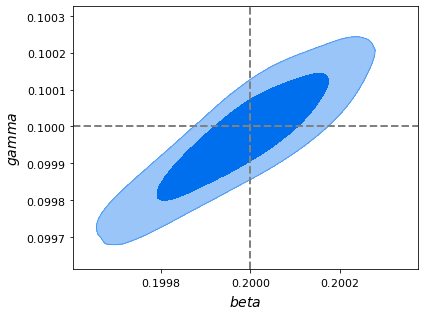

In [81]:
p = gdplt.get_single_plotter(width_inch=6)
p.plot_2d(gdsamples, ["beta", "gamma"], filled=True)
p.add_x_marker(beta, lw = 2)
p.add_y_marker(gamma, lw = 2)

In [3]:
class MyLikelihood(Likelihood):

    def initialize(self):
        """
         Prepare any computation, importing any necessary code, files, etc.

         e.g. here we load some data file, with default cl_file set in .yaml below,
         or overridden when running Cobaya.
        """

        self.I_data = I_data

    def get_requirements(self):
        """
         return dictionary specifying quantities calculated by a theory code are needed

         e.g. here we need C_L^{tt} to lmax=2500 and the H0 value
        """
        return {'Cl': {'tt': 2500}, 'H0': None}

    def logp(self, **params_values):
        """
        Taking a dictionary of (sampled) nuisance parameter values params_values
        and return a log-likelihood.

        e.g. here we calculate chi^2  using cls['tt'], H0_theory, my_foreground_amp
        """
        H0_theory = self.provider.get_param("beta")
        gamma_theory = self.provider.get_param("beta")
        _, I_theory, _ = integrate_SIR(S0, I0, R0, ndays, beta_theory, gamma_theory)

        chi2 = np.sum((I_theory - self.I_data)**2.)
        return -chi2 / 2

In [71]:
np.sum((I_data - I_data_noiseless)**2)

1.6008539134637971